## Image classification with Convolutional Neural Networks - 'baseball vs football'

In this project we are going to be using convolutional neural networks(CNNs) for image classification. More specifically we are going to try to create a model that can successfully classify wiether an image is an image of a baseball, or an image of a football(soccerball).
This project is based on a lesson from the fast.ai course(https://course.fast.ai/).

## Hardware Setup
The first thing that we needed for the project, is a machine that has a Nvidia GPU, as Nvidia GPUs use CUDA, the programming framework used behind the scenes for the project. Unfortunately, I do not have such a machine, so I had to rent a cloud machine for this project. <br>
The service that I decided to use was Paperspace, as this is one was recommended by the fast.ai course. So using this service, I setup a cloud machine that was running Ubuntu 16.04.<br>
Whilst Paperspace does provide a terminal in the browser, I found it more convenient to SSH into the Paperspace machine from my local machine using a Ubuntu client for Windows.<br>

## Project Dataset
For this project I will be using an set of 200 images; 100 labelled baseball images, and 100 labelled football images.<br>
100 images are available for training, and 100 images are available for validation.<br>
For this project, the library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'baseball' and 'football').

## Project Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#### Libraries
The main library for this project is the fastai library. The fastai library simplifies training fast and accurate neural nets using modern best practices. The library is based on research into deep learning best practices undertaken at fast.ai, and includes "out of the box" support for vision, text, tabular, and collab (collaborative filtering) models. 

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

#### Path
`PATH` is the path to our data - as stated before the folder must have *train* and *valid* directories with subdirectories for each class.

In [4]:
PATH = "../../../data/bf/"
sz=224

## Checking our dataset
Here we are going to check that everything in our dataset is correct before we proceed.

In [9]:
os.listdir(PATH)

['.ipynb_checkpoints', 'sample', 'valid', 'models', 'train', 'tmp']

In [10]:
os.listdir(f'{PATH}valid')

['football', 'baseball']

In [11]:
files = os.listdir(f'{PATH}valid/baseball')[:5]
files

['Ball-Glove-1000x563.jpg',
 '6054285-baseball-pictures.jpg',
 'big_6d53fc9c87c54f279b5ded46c4a2ffad.jpg',
 'BaseballStockWeb.jpg',
 '6140vZfSU4L._SX425_.jpg']

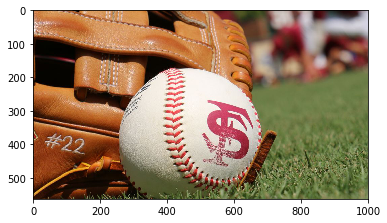

In [12]:
img = plt.imread(f'{PATH}valid/baseball/{files[0]}')
plt.imshow(img);

## Our Model

We're going to use a pre-trained model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. 

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. 

We will now train and evaluate a *baseball vs football* model.

In [16]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy               
    0      0.73479    0.292067   0.98      
    1      0.535403   0.172922   0.98            



[array([0.17292]), 0.98]

## Analyzing inital results
As can be seen from our results, the model has a 98% accuracy in classifying an image correctly. This is pretty amazing considering we only have three lines of code, and is a testament to power of the fastai library.

As well as looking at the overall metrics, we will also look at:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [19]:
log_preds = learn.predict()
log_preds.shape

(100, 2)

In [21]:
preds = np.argmax(log_preds, axis=1)  
probs = np.exp(log_preds[:,1])        

In [28]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=True)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [23]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [24]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

### 1. A few correct labels at random
*NOTE:* Value < 0.5, indicates a baseball, while a value > 0.5, indicates a football 

Correctly classified


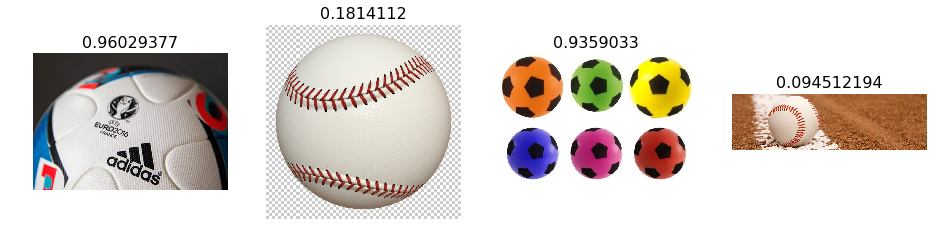

In [25]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

### 2. A few incorrect labels at random
*NOTE:* As there are only two incorrect labels, two of the labels have been repeated.

Incorrectly classified


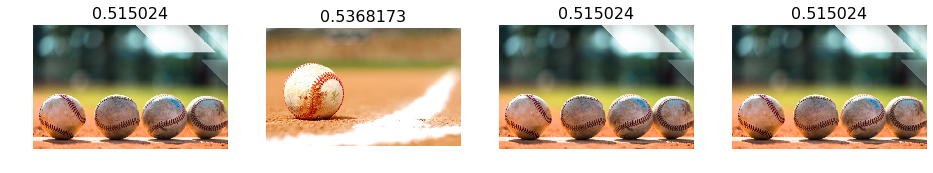

In [29]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [30]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

### 3.1. Most correct baseballs

Most correct baseballs


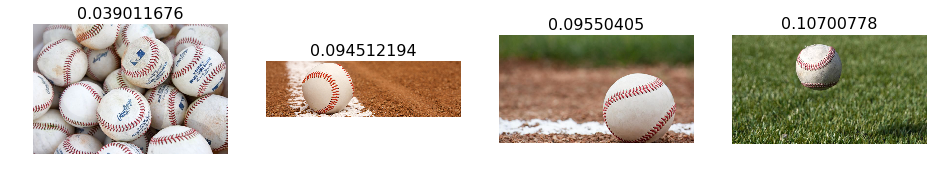

In [32]:
plot_val_with_title(most_by_correct(0, True), "Most correct baseballs")

### 3.2. Most correct footballs

Most correct footballs


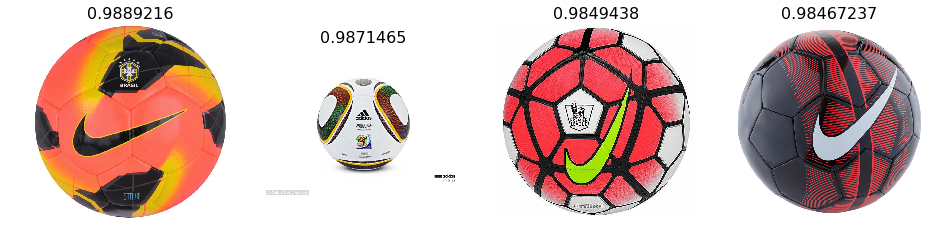

In [33]:
plot_val_with_title(most_by_correct(1, True), "Most correct footballs")

### 4.1. Most incorrect baseballs

Most incorrect baseballs


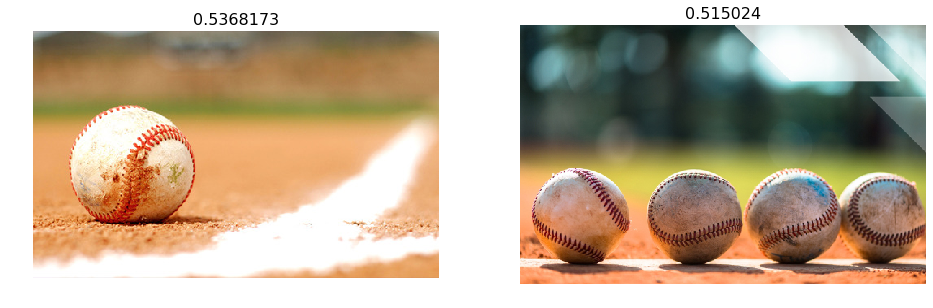

In [34]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect baseballs")

### 4.2. Most incorrect footballs
*NOTE:* There were no incorrectly classfied footballs

In [35]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect footballs")

Most incorrect footballs
Not Found.


### 5. Most uncertain predictions

Most uncertain predictions


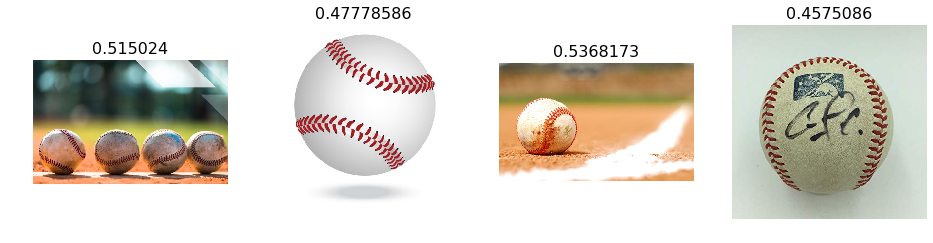

In [36]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Improving our model

### Learning Rate
The initial learning rate of the model was 1e-2(0.01). I ran some tests with different learning rates, but actually seen a decrease in the accuracy of the model, so I have left the learning rate at 0.01

### Fine-tuning with differential learning rates.

We can try fine-tuning the layers by unfreezing the layers, which we do by calling `unfreeze()`.

In [54]:
learn.unfreeze()

Note that the layers have *already* been trained to recognize imagenet photos, so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features, like lines and curves etc. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*.

In [55]:
lr=np.array([1e-4,1e-3,1e-2])

In [56]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.470965   0.116249   1.0       
    1      0.39072    0.096682   1.0                     
    2      0.351273   0.093536   1.0                     
    3      0.322844   0.069632   1.0                     
    4      0.288102   0.0516     1.0                     
    5      0.255528   0.04461    1.0                     
    6      0.222695   0.044168   1.0                     



[array([0.04417]), 1.0]

## Analyzing final results
As can be seen, the model now has a 100% accuracy when classifying an image as a baseball or a football.

## Conclusion and final thoughts
I was pleased with the final results of the model, however there are a few techniques that I did not use in this project that I would like to use in future projects.

#### Learning rates
In this project, I arbitrarily chose the learning rate, which ended up being an ideal learning rate. However, the fastai library does offer methods that aid you in being more deliberate when choosing your learning rate. I will make use of these methods in future projects.

#### Data Augmentation
Data augmentation allows us to increase the size of our dataset by slightly augmenting the images, by zooming, transforming etc, and putting these augmented images back into the dataset as a new images to work with.
I would like to use this technique in future projects

#### Thanks
To conclude, I would like to thank Jeremy Howard and the other fantastic folks at fast.ai for providing such an amazing free resource for people who are interested in learning deep learning. Thanks folks!